In [126]:
# A vanilla GAN
import torch
import torch.nn as nn
import torch.optim as optim


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(400, 256)
        self.fc2 = nn.Linear(256, 28*28)
        self.ConvTranspose2d = nn.ConvTranspose2d(2, 1, 3, padding=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # x = x.view(-1, 2, 28, 28)
        # x = torch.sigmoid(self.ConvTranspose2d(x))
        # print(x.size())
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # x = x.view(-1, 1, 28, 28)
        # x = torch.relu(self.conv1(x))
        x = x.view(-1, 784)
        # print(x.size())
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

def train_gan(generator, discriminator, train_loader, num_epochs=10):
    criterion = nn.BCELoss()
    optimizer_g = optim.SGD(generator.parameters(), lr=0.0001)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(train_loader):
            real_images = real_images.view(-1, 784).to('cuda')
            real_labels = torch.ones(real_images.size(0), 1).to('cuda')
            fake_labels = torch.zeros(real_images.size(0), 1).to('cuda')

            # Train the discriminator
            discriminator.zero_grad()
            outputs = discriminator(real_images)
            real_loss = criterion(outputs, real_labels)
            real_score = outputs

            z = torch.randn(real_images.size(0), 400).to('cuda')
            fake_images = generator(z)
            outputs = discriminator(fake_images)
            fake_loss = criterion(outputs, fake_labels)
            fake_score = outputs

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_d.step()

            # Train the generator
            generator.zero_grad()
            z = torch.randn(real_images.size(0), 400).to('cuda')
            fake_images = generator(z)
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            optimizer_g.step()

            if (i+1) % 100 == 0:
                print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, '
                      'D(x): %.2f, D(G(z)): %.2f'
                      %(epoch, num_epochs, i+1, len(train_loader),
                        d_loss.item(), g_loss.item(),
                        real_score.data.mean(), fake_score.data.mean()))

    return generator, discriminator



In [127]:
# load data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import numpy as np
from torch.utils.data import Dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

X_train = np.load('../hw1_nn/mnist/X_train.npy')
y_train = np.load('../hw1_nn/mnist/y_train.npy')
X_val = np.load('../hw1_nn/mnist/X_val.npy')
y_val = np.load('../hw1_nn/mnist/y_val.npy')
X_test = np.load('../hw1_nn/mnist/X_test.npy')
y_test = np.load('../hw1_nn/mnist/y_test.npy')


# 定义MNIST数据集类
class MNISTDataset(Dataset):  # 继承Dataset类

    def __init__(self, data=X_train, label=y_train):
        '''
        Args:
            data: numpy array, shape=(N, 784)
            label: numpy array, shape=(N, 10)
        '''
        self.data = data
        self.label = label

    def __getitem__(self, index):
        '''
        根据索引获取数据,返回数据和标签,一个tuple
        '''
        data = self.data[index].astype('float32')  # 转换数据类型, 神经网络一般使用float32作为输入的数据类型
        label = self.label[index].astype('int64')  # 转换数据类型, 分类任务神经网络一般使用int64作为标签的数据类型
        return data, label

    def __len__(self):
        '''
        返回数据集的样本数量
        '''
        return len(self.data)
train_loader = DataLoader(MNISTDataset(X_train, y_train),
                          batch_size=256, shuffle=True)
val_loader = DataLoader(MNISTDataset(X_val, y_val),
                        batch_size=256, shuffle=True)
test_loader = DataLoader(MNISTDataset(X_test, y_test),
                         batch_size=256, shuffle=True)

In [128]:
# train
generator = Generator().to('cuda')
discriminator = Discriminator().to('cuda')
generator, discriminator = train_gan(generator, discriminator, train_loader, num_epochs=50)


Epoch [0/50], Step[100/196], d_loss: 0.0389, g_loss: 3.7779, D(x): 0.99, D(G(z)): 0.02
Epoch [1/50], Step[100/196], d_loss: 0.0059, g_loss: 5.5718, D(x): 1.00, D(G(z)): 0.00
Epoch [2/50], Step[100/196], d_loss: 0.0038, g_loss: 6.2061, D(x): 1.00, D(G(z)): 0.00
Epoch [3/50], Step[100/196], d_loss: 0.0026, g_loss: 6.3688, D(x): 1.00, D(G(z)): 0.00
Epoch [4/50], Step[100/196], d_loss: 0.0021, g_loss: 6.6352, D(x): 1.00, D(G(z)): 0.00
Epoch [5/50], Step[100/196], d_loss: 0.0033, g_loss: 6.3437, D(x): 1.00, D(G(z)): 0.00
Epoch [6/50], Step[100/196], d_loss: 0.0062, g_loss: 5.6812, D(x): 1.00, D(G(z)): 0.00
Epoch [7/50], Step[100/196], d_loss: 0.0187, g_loss: 5.0469, D(x): 0.99, D(G(z)): 0.01
Epoch [8/50], Step[100/196], d_loss: 0.0411, g_loss: 4.8092, D(x): 0.99, D(G(z)): 0.02
Epoch [9/50], Step[100/196], d_loss: 0.0424, g_loss: 4.5380, D(x): 0.99, D(G(z)): 0.03
Epoch [10/50], Step[100/196], d_loss: 0.1098, g_loss: 4.1302, D(x): 0.97, D(G(z)): 0.04
Epoch [11/50], Step[100/196], d_loss: 0.23

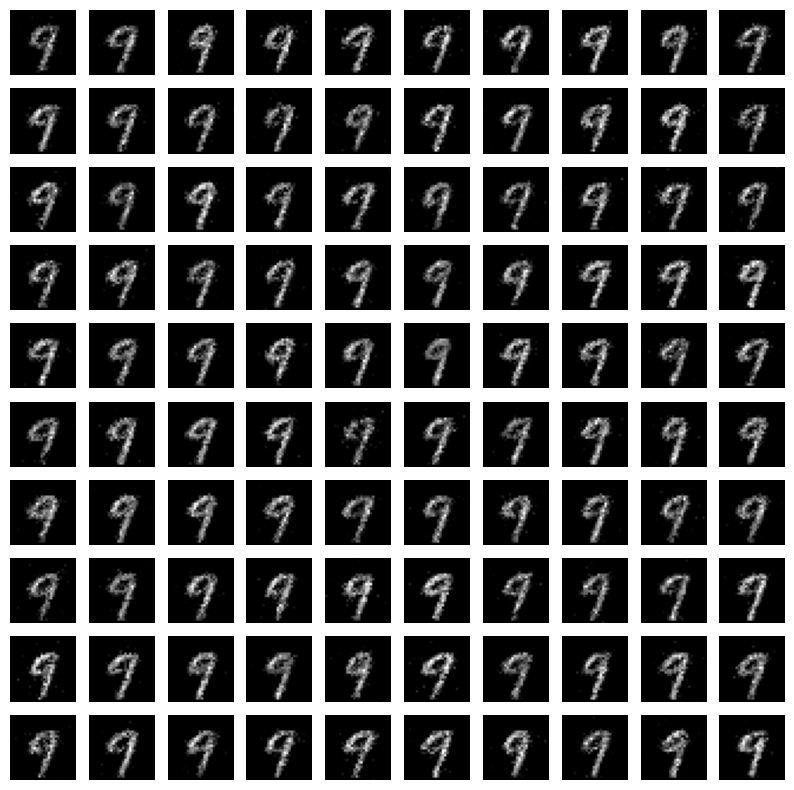

In [129]:
# generate images
import matplotlib.pyplot as plt

z = torch.randn(100, 400).to('cuda')
fake_images = generator(z).to('cpu')
fake_images = fake_images.view(fake_images.size(0), 28, 28)
fake_images = fake_images.detach().numpy()

plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(fake_images[i], cmap='gray')
    plt.axis('off')
plt.show()
